# ADD DATA AUGMENTATION
# ADD CENTERING/CONTOUR
# IMPROVE ARCHITECTURE

In [100]:
import os
import random
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras import Model

os.chdir("C:\\Users\\Jakub\\Documents\\tumor_detection")

# Loading the data

In [2]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    labels='inferred',
    label_mode='binary',
    class_names=["no","yes"],
    color_mode='grayscale',
    batch_size=32,
    image_size=(256,256))

Found 253 files belonging to 2 classes.


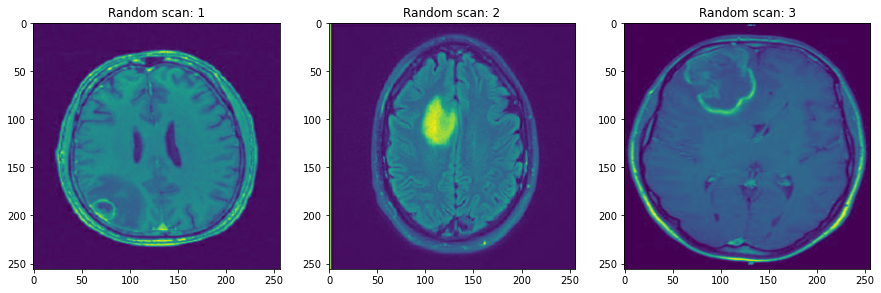

In [114]:
# Create the figure and axes objects
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(ax)):
    batch = next(iter(data.shuffle(1)))
    img = batch[0][0]
    ax[i].imshow(img)
    ax[i].set_title("Random scan: " + str(i+1))

# Show the plots
plt.show()

# Pre-processing

### Split the data

In [4]:
num_samples = data.cardinality().numpy()
num_train_samples = int(0.8 * num_samples)

# Take the first num_train_samples elements for training
train_data = data.take(num_train_samples)
# Skip the first num_train_samples elements for testing
val_data = data.skip(num_train_samples)

# Training

In [5]:
import tensorflow as tf

# Input layer
inputs = tf.keras.Input(shape=(256, 256, 1))

# Convolutional layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flatten and Dense layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC()])

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)

history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
6/6 [==============================] - 5s 785ms/step - loss: 223.1656 - auc: 0.5776 - val_loss: 30.0396 - val_auc: 0.5000
Epoch 2/20
6/6 [==============================] - 5s 753ms/step - loss: 10.6039 - auc: 0.5382 - val_loss: 4.4065 - val_auc: 0.5000
Epoch 3/20
6/6 [==============================] - 4s 752ms/step - loss: 2.5609 - auc: 0.6799 - val_loss: 1.0786 - val_auc: 0.9368
Epoch 4/20
6/6 [==============================] - 5s 755ms/step - loss: 0.9070 - auc: 0.7925 - val_loss: 0.5976 - val_auc: 0.8347
Epoch 5/20
6/6 [==============================] - 5s 756ms/step - loss: 0.5756 - auc: 0.8102 - val_loss: 0.4425 - val_auc: 0.8743
Epoch 6/20
6/6 [==============================] - 5s 757ms/step - loss: 0.4290 - auc: 0.8667 - val_loss: 0.5467 - val_auc: 0.8524


In [10]:
import plotly.graph_objects as go

# Create a line chart with the training accuracy
trace1 = go.Scatter(x=list(range(1, len(history.history['auc'])+1)), y=history.history['auc'], name='Train',
                    mode='lines+markers', hoverlabel=dict(namelength=-1))

# Create a line chart with the validation accuracy
trace2 = go.Scatter(x=list(range(1, len(history.history['val_auc'])+1)), y=history.history['val_auc'], name='Validation',
                    mode='lines+markers', hoverlabel=dict(namelength=-1))

# Create a layout for the chart
layout = go.Layout(xaxis=dict(title='Epoch'),
                   yaxis=dict(title='AUC'),
                   width=800,
                   height=400,
                   template='seaborn')

# Create a figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()

# Model analysis

In [97]:
def visualize_layer_output(model, layer_name):
    # Create a new model that outputs the activations of the specified layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    # Get the activations of the specified layer
    intermediate_output = intermediate_layer_model.predict(data)

    # Create a 3x3 grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Select three random channels
    random_channels = random.sample(range(intermediate_output.shape[-1]), 3)
    # Loop over the selected channels and plot the activations in each subplot
    for i, channel in enumerate(random_channels):
        output_2d = intermediate_output[:, :, :, channel].mean(axis=0)
        axs[i].imshow(output_2d, cmap='coolwarm')
        axs[i].axis('off')
        axs[i].set_title("channel {}".format(channel))
    plt.suptitle(f"Activations of {layer_name} layer", fontsize=20)
    plt.show()

8/8 [==============================] - 1s 51ms/step


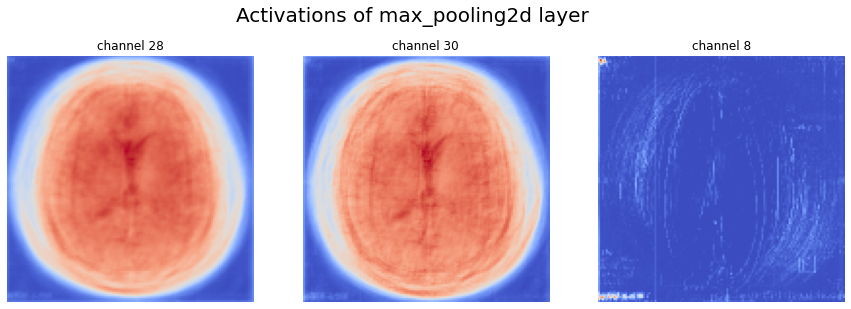

8/8 [==============================] - 1s 104ms/step


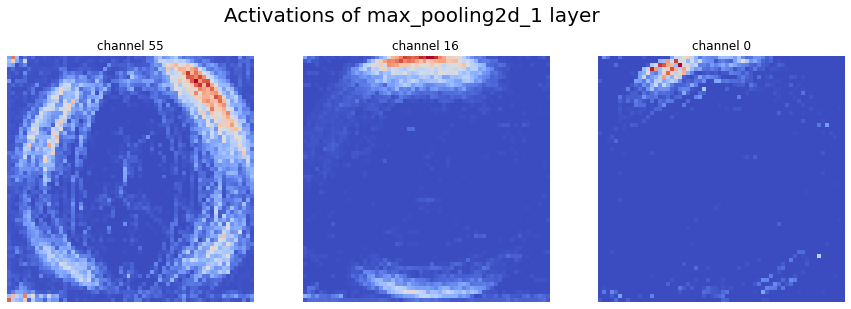

8/8 [==============================] - 1s 141ms/step


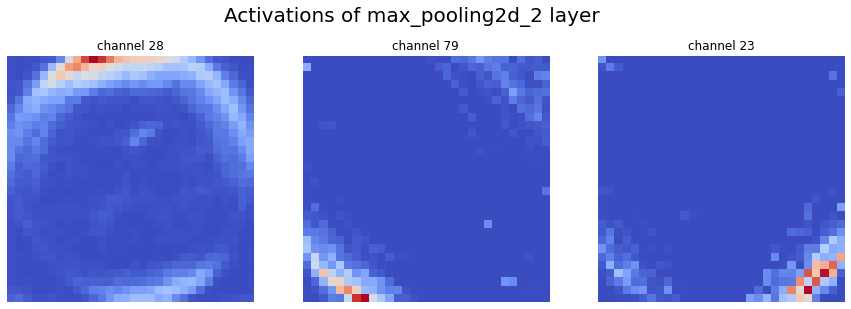

In [98]:
visualize_layer_output(model, 'max_pooling2d')
visualize_layer_output(model, 'max_pooling2d_1')
visualize_layer_output(model, 'max_pooling2d_2')